In [1]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListTusz
from lib.signals import EegProcessorTusz
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.stats import StatisticalTests
from lib.bss import EogDenoiser, EmgDenoiser
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

/var/tmp/venv-project-1/lib/python3.11/site-packages/numpy/_core/getlimits.py:548: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### * Scales the EEG signal
### * Select a subset of the channels

{
    "cpsz": 279,
    "fnsz": 1549,
    "gnsz": 444,
    "tcsz": 30,
    "absz": 50,
    "mysz": 2,
    "tnsz": 18,
    "spsz": 49
}
{'full_file': '/mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaenl/s001_2006/02_tcp_le/aaaaaenl_s001_t001.edf', 'seizures': [(0.0, 0.0, 'bckg'), [112.012, 128.46, 'absz']]}
Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/tusz/edf/train/aaaaaenl/s001_2006/02_tcp_le/aaaaaenl_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-06-11 22:43:26,459 - root - INFO - Recording contains channels = ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE', 'EEG C4-LE', 'EEG A1-LE', 'EEG A2-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE', 'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE', 'EEG OZ-LE', 'EEG PG1-LE', 'EEG PG2-LE', 'EEG EKG-LE', 'EEG 26-LE', 'EEG 27-LE', 'EEG 28-LE', 'EEG 29-LE', 

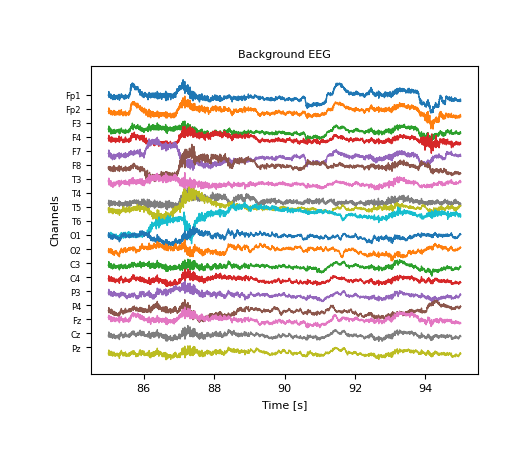

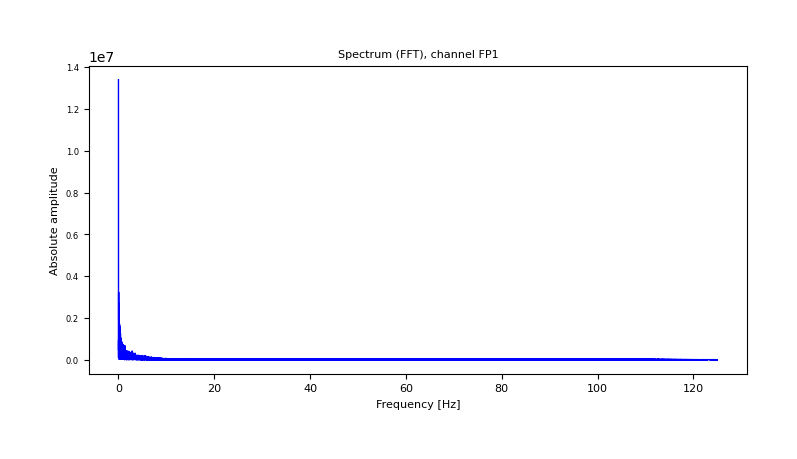

In [2]:
PATIENT = "aaaaaenl"
FILENAME = "aaaaaenl_s001_t001"
PERIOD = [85, 95]

###########################################################
metadata = MetadataListTusz()
metadata.summarize()
current_metadata = metadata.get(PATIENT, FILENAME)
print(current_metadata)
###########################################################
processor = EegProcessorTusz(current_metadata["full_file"])
processor.scale()
processor.select_channels()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD, "sample_eeg.png")

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

### * Resample the EEG to 256Hz

2025-06-11 22:43:44,118 - root - INFO - Selected frequency is = 250
2025-06-11 22:43:44,119 - root - INFO - Dowsampling factor is = 1


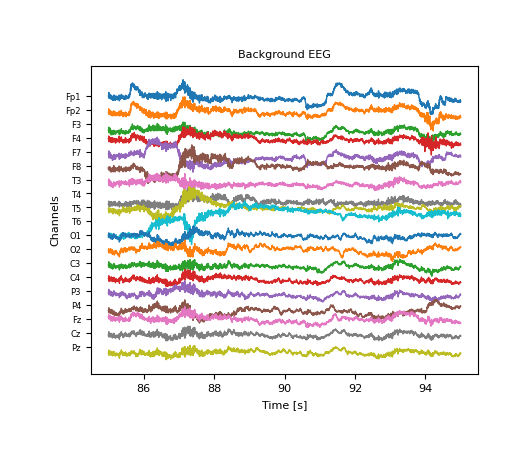

In [3]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)


### * Remove the drift noise, high frequency oscillations, power line noise

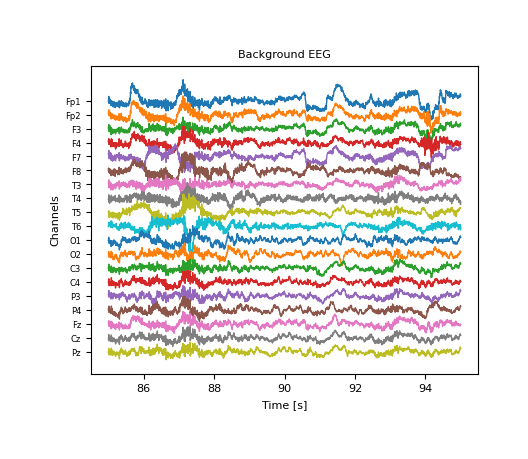

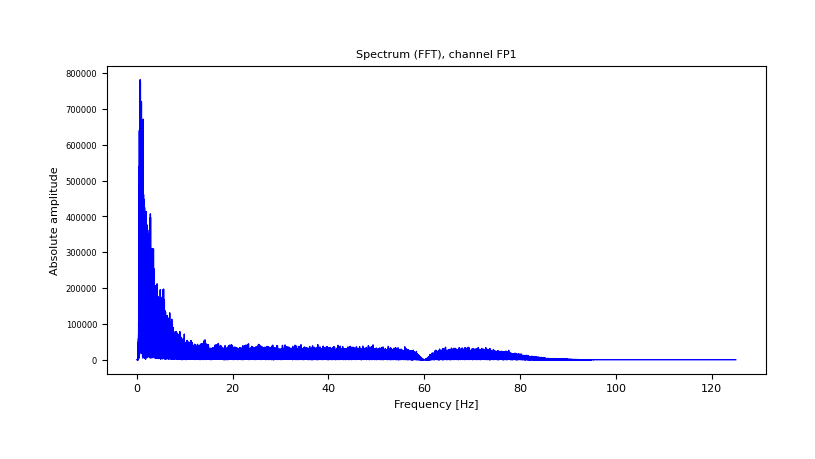

In [4]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "FP1")

### * Separated sources using iWASOBI

2025-06-11 22:44:14,124 - root - INFO - Number of sources to be removed = 2, indices: [4 3]
Source = 1, fd = 4.169861753991048
Source = 2, fd = 4.302887034645622
Source = 3, fd = 4.494088024368807
Source = 4, fd = 4.5419315575401775
Source = 5, fd = 4.7213623255281805
Source = 6, fd = 4.755578526365006
Source = 7, fd = 4.853444319676656
Source = 8, fd = 4.864443561689287
Source = 9, fd = 4.954620495322484
Source = 10, fd = 5.5431149841477865
Source = 11, fd = 5.619590642692761
Source = 12, fd = 5.679258563677715
Source = 13, fd = 5.8235467333318525
Source = 14, fd = 5.959627757353907
Source = 15, fd = 6.009955431720844
Source = 16, fd = 6.1247837190107814
Source = 17, fd = 6.276636409398154
Source = 18, fd = 6.283560824690207
Source = 19, fd = 6.328593967501775
Done!


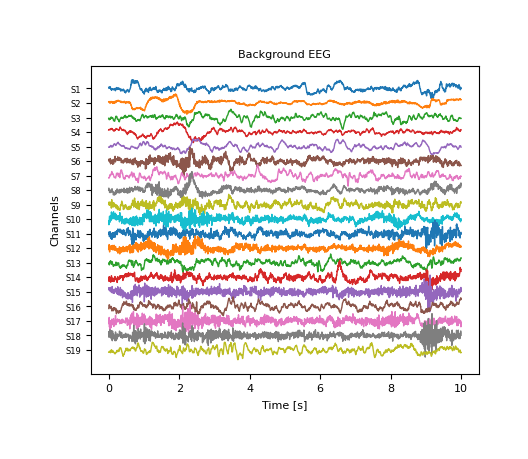

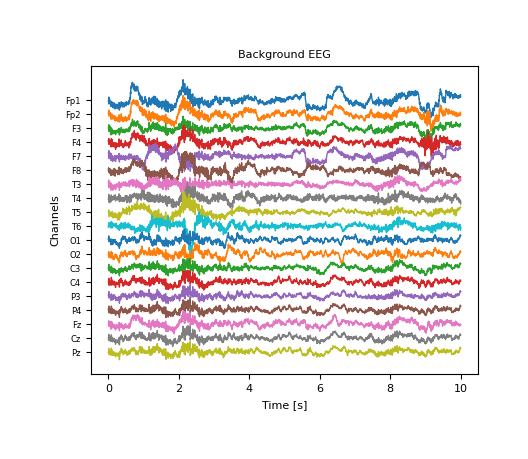

In [5]:
eog_denoiser = EogDenoiser(processor.sampling_frequency)
eeg_sources, clean_eog_eeg = eog_denoiser.apply_by_segments(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                            PERIOD[1]*processor.sampling_frequency])
print(eog_denoiser)

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
plot_eeg_windows(clean_eog_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

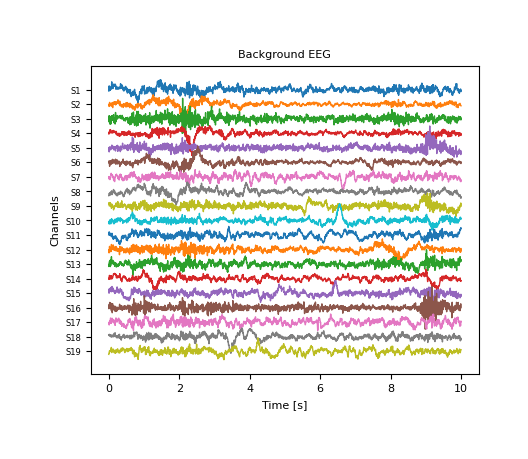

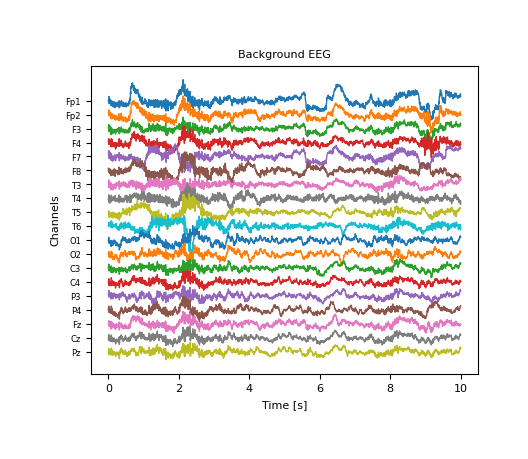

In [6]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
#eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

2025-06-11 22:44:48,148 - root - INFO - Number of sources to be removed = 0
Source = 1, fd = 22.069397975488496
Source = 2, fd = 23.280998942118075
Source = 3, fd = 24.253082562482227
Source = 4, fd = 31.81131760885145
Source = 5, fd = 40.29446152239751
Source = 6, fd = 46.63396237404705
Source = 7, fd = 47.98696301343784
Source = 8, fd = 49.71756293418342
Source = 9, fd = 54.30164168848825
Source = 10, fd = 67.52055412097921
Source = 11, fd = 73.91481255079685
Source = 12, fd = 77.35178099434044
Source = 13, fd = 90.39127568810298
Source = 14, fd = 93.18196444071832
Source = 15, fd = 97.15272278026528
Source = 16, fd = 114.15970043932457
Source = 17, fd = 142.50953627201935
Source = 18, fd = 153.07530800637625
Source = 19, fd = 174.2084272358688
Done!


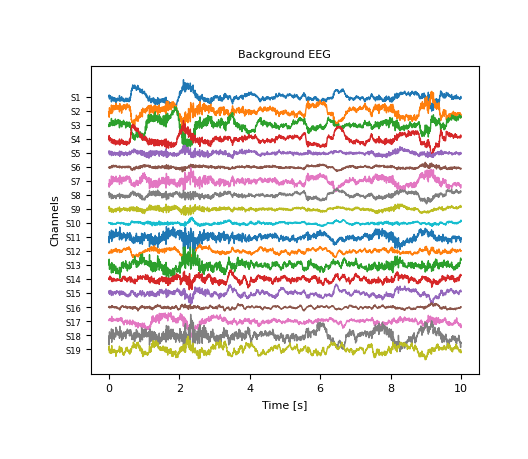

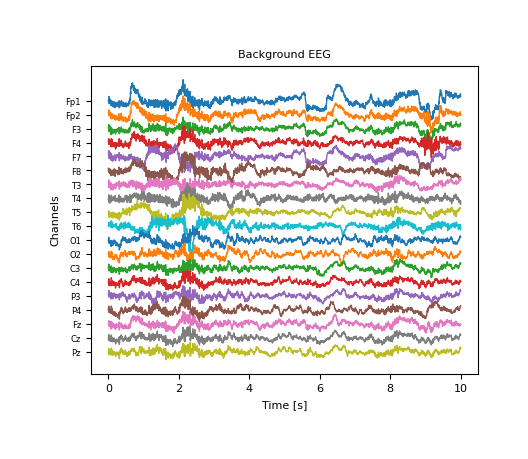

In [9]:
emg_denoiser = EmgDenoiser(processor.sampling_frequency)
eeg_sources, clean_emg_eeg = emg_denoiser.apply_by_segments(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                            PERIOD[1]*processor.sampling_frequency])
print(emg_denoiser)

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
plot_eeg_windows(clean_emg_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Re-referencing to average reference

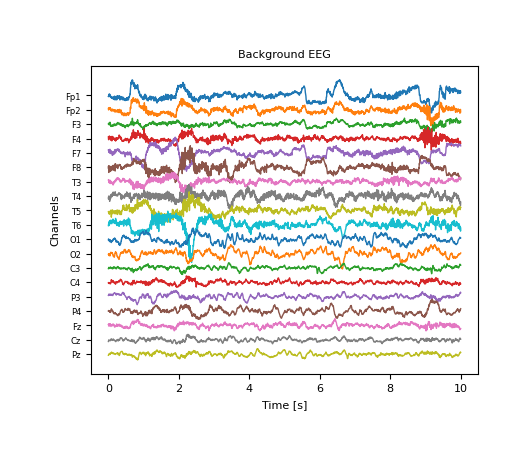

In [19]:
###########################################################
referenced_eeg = processor.rereference_to_average(clean_emg_eeg)

###########################################################
PERIOD = [0, PERIOD[1] - PERIOD[0]]
plot_eeg_windows(referenced_eeg, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Stationarity tests (KPPS and ADF)

In [20]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[15, :4000])

2025-06-11 22:48:52,270 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-06-11 22:48:52,274 - root - INFO - White test, null hyphotesis was rejected, p_value = 2.1186725150991513e-72, significance level = 0.05
2025-06-11 22:48:52,275 - root - INFO - The series is trend stationary only (not strict stationarity)


/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/stats.py:134: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  _, p_value, _, _ = stattools.kpss(time_serie, regression="c")


'Trend stationary'